In [1]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="https://developer.download.nvidia.com/tesla/notebook_assets/nv_logo_torch_trt_ssd_notebook.png" style="width: 90px; float: right;">

# Object Detection with Torch-TensorRT (SSD)

---
## Overview

In the practice of developing machine learning models, there are few tools as approachable as PyTorch for developing and experimenting in designing machine learning models. The power of PyTorch comes from its deep integration into Python, its flexibility and its approach to automatic differentiation and execution (eager execution). However, when moving from research into production, the requirements change and we may no longer want that deep Python integration and we want optimization to get the best performance we can on our deployment platform. In PyTorch 1.0, TorchScript was introduced as a method to separate your PyTorch model from Python, make it portable and optimizable. TorchScript uses PyTorch's JIT compiler to transform your normal PyTorch code which gets interpreted by the Python interpreter to an intermediate representation (IR) which can have optimizations run on it and at runtime can get interpreted by the PyTorch JIT interpreter. For PyTorch this has opened up a whole new world of possibilities, including deployment in other languages like C++. It also introduces a structured graph based format that we can use to do down to the kernel level optimization of models for inference.

When deploying on NVIDIA GPUs TensorRT, NVIDIA's Deep Learning Optimization SDK and Runtime is able to take models from any major framework and specifically tune them to perform better on specific target hardware in the NVIDIA family be it an A100, TITAN V, Jetson Xavier or NVIDIA's Deep Learning Accelerator. TensorRT performs a couple sets of optimizations to achieve this. TensorRT fuses layers and tensors in the model graph, it then uses a large kernel library to select implementations that perform best on the target GPU. TensorRT also has strong support for reduced operating precision execution which allows users to leverage the Tensor Cores on Volta and newer GPUs as well as reducing memory and computation footprints on device.

Torch-TensorRT is a compiler that uses TensorRT to optimize TorchScript code, compiling standard TorchScript modules into ones that internally run with TensorRT optimizations. This enables you to continue to remain in the PyTorch ecosystem, using all the great features PyTorch has such as module composability, its flexible tensor implementation, data loaders and more. Torch-TensorRT is available to use with both PyTorch and LibTorch.

### Learning objectives

This notebook demonstrates the steps for compiling a TorchScript module with Torch-TensorRT on a pretrained SSD network, and running it to test the speedup obtained.

## Contents
1. [Requirements](#1)
2. [SSD Overview](#2)
3. [Creating TorchScript modules](#3)
4. [Compiling with Torch-TensorRT](#4)
5. [Running Inference](#5)
6. [Measuring Speedup](#6)
7. [Conclusion](#7)

---
<a id="1"></a>
## 1. Requirements

Follow the steps in `notebooks/README` to prepare a Docker container, within which you can run this demo notebook.

In addition to that, run the following cell to obtain additional libraries specific to this demo.

In [2]:
!pip install scikit-image==0.19.1
!pip install ipywidgets --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 13.8 MB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 110.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 42.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 61.3 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 123 kB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 245 kB 60.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 35.2 MB/s eta 0:00:01


---
<a id="2"></a>
## 2. SSD

### Single Shot MultiBox Detector model for object detection

_ | _
- | -
![alt](https://pytorch.org/assets/images/ssd_diagram.png) | ![alt](https://pytorch.org/assets/images/ssd.png)

PyTorch has a model repository called the PyTorch Hub, which is a source for high quality implementations of common models. We can get our SSD model pretrained on [COCO](https://cocodataset.org/#home) from there.

### Model Description

This SSD300 model is based on the
[SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper, which
describes SSD as “a method for detecting objects in images using a single deep neural network".
The input size is fixed to 300x300.

The main difference between this model and the one described in the paper is in the backbone.
Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

From the
[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)
paper, the following enhancements were made to the backbone:
*   The conv5_x, avgpool, fc and softmax layers were removed from the original classification model.
*   All strides in conv4_x are set to 1x1.

The backbone is followed by 5 additional convolutional layers.
In addition to the convolutional layers, we attached 6 detection heads:
*   The first detection head is attached to the last conv4_x layer.
*   The other five detection heads are attached to the corresponding 5 additional layers.

Detector heads are similar to the ones referenced in the paper, however,
they are enhanced by additional BatchNorm layers after each convolution.

More information about this SSD model is available at Nvidia's "DeepLearningExamples" Github [here](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD).

In [3]:
import torch
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

In [4]:
# List of available models in PyTorch Hub from Nvidia/DeepLearningExamples
torch.hub.list('NVIDIA/DeepLearningExamples:torchhub')

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


['nvidia_convnets_processing_utils',
 'nvidia_efficientnet',
 'nvidia_efficientnet_b0',
 'nvidia_efficientnet_b4',
 'nvidia_efficientnet_widese_b0',
 'nvidia_efficientnet_widese_b4',
 'nvidia_resneXt',
 'nvidia_resnet50',
 'nvidia_resnext101_32x4d',
 'nvidia_se_resnext101_32x4d',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_tts_utils',
 'nvidia_waveglow']

In [5]:
# load SSD model pretrained on COCO from Torch Hub
precision = 'fp32'
ssd300 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision);

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Setting `precision="fp16"` will load a checkpoint trained with mixed precision 
into architecture enabling execution on Tensor Cores. Handling mixed precision data requires the Apex library.

### Sample Inference

We can now run inference on the model. This is demonstrated below using sample images from the COCO 2017 Validation set.

In [6]:
# Sample images from the COCO validation set
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

# For convenient and comprehensive formatting of input and output of the model, load a set of utility methods.
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

# Format images to comply with the network input
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, False)

# The model was trained on COCO dataset, which we need to access in order to
# translate class IDs into object names. 
classes_to_labels = utils.get_coco_object_dictionary()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [7]:
# Next, we run object detection
model = ssd300.eval().to("cuda")
detections_batch = model(tensor)

# By default, raw output from SSD network per input image contains 8732 boxes with 
# localization and class probability distribution. 
# Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

### Visualize results

In [8]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# The utility plots the images and predicted bounding boxes (with confidence scores).
def plot_results(best_results):
    for image_idx in range(len(best_results)):
        fig, ax = plt.subplots(1)
        # Show original, denormalized image...
        image = inputs[image_idx] / 2 + 0.5
        ax.imshow(image)
        # ...with detections
        bboxes, classes, confidences = best_results[image_idx]
        for idx in range(len(bboxes)):
            left, bot, right, top = bboxes[idx]
            x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


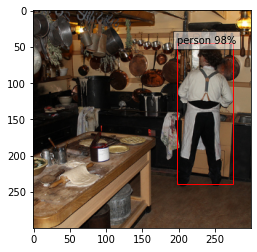

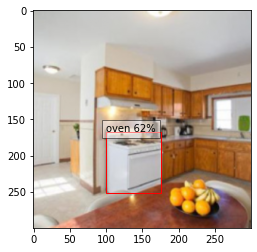

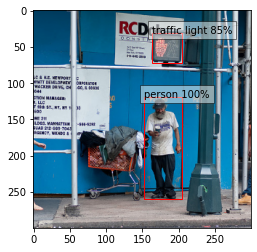

In [9]:
# Visualize results without Torch-TensorRT
plot_results(best_results_per_input)

### Benchmark utility

In [10]:
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

# Helper function to benchmark the model
def benchmark(model, input_shape=(1024, 1, 32, 32), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc, pred_label  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output location prediction size:", pred_loc.size())
    print("Output label prediction size:", pred_label.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))


We check how well the model performs **before** we use Torch-TensorRT

In [11]:
# Model benchmark without Torch-TensorRT
model = ssd300.eval().to("cuda")
benchmark(model, input_shape=(128, 3, 300, 300), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 165.38 ms
Iteration 20/100, avg batch time 165.99 ms
Iteration 30/100, avg batch time 166.04 ms
Iteration 40/100, avg batch time 166.32 ms
Iteration 50/100, avg batch time 166.49 ms
Iteration 60/100, avg batch time 166.74 ms
Iteration 70/100, avg batch time 166.88 ms
Iteration 80/100, avg batch time 167.05 ms
Iteration 90/100, avg batch time 167.18 ms
Iteration 100/100, avg batch time 167.31 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 167.31 ms


---
<a id="3"></a>
## 3. Creating TorchScript modules  

To compile with Torch-TensorRT, the model must first be in **TorchScript**. TorchScript is a programming language included in PyTorch which removes the Python dependency normal PyTorch models have. This conversion is done via a JIT compiler which given a PyTorch Module will generate an equivalent TorchScript Module. There are two paths that can be used to generate TorchScript: **Tracing** and **Scripting**. <br>
- Tracing follows execution of PyTorch generating ops in TorchScript corresponding to what it sees. <br>
- Scripting does an analysis of the Python code and generates TorchScript, this allows the resulting graph to include control flow which tracing cannot do. 

Tracing however due to its simplicity is more likely to compile successfully with Torch-TensorRT (though both systems are supported).

In [12]:
model = ssd300.eval().to("cuda")
traced_model = torch.jit.trace(model, [torch.randn((1,3,300,300)).to("cuda")])

If required, we can also save this model and use it independently of Python.

In [13]:
# This is just an example, and not required for the purposes of this demo
torch.jit.save(traced_model, "ssd_300_traced.jit.pt")

In [14]:
# Obtain the average time taken by a batch of input with Torchscript compiled modules
benchmark(traced_model, input_shape=(128, 3, 300, 300), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 165.53 ms
Iteration 20/100, avg batch time 166.19 ms
Iteration 30/100, avg batch time 166.12 ms
Iteration 40/100, avg batch time 166.16 ms
Iteration 50/100, avg batch time 166.24 ms
Iteration 60/100, avg batch time 166.33 ms
Iteration 70/100, avg batch time 166.43 ms
Iteration 80/100, avg batch time 166.44 ms
Iteration 90/100, avg batch time 166.53 ms
Iteration 100/100, avg batch time 166.59 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 166.59 ms


---
<a id="4"></a>
## 4. Compiling with Torch-TensorRT
TorchScript modules behave just like normal PyTorch modules and are intercompatible. From TorchScript we can now compile a TensorRT based module. This module will still be implemented in TorchScript but all the computation will be done in TensorRT.

In [15]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.
trt_model = torch_tensorrt.compile(traced_model, 
    inputs= [torch_tensorrt.Input((3, 3, 300, 300), dtype=torch.half)],
    enabled_precisions= {torch.half}, # Run with FP16
    workspace_size= 1 << 20
)

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x
- Disable partial compilation by setting require_full_compilation to True


---
<a id="5"></a>
## 5. Running Inference

Next, we run object detection

In [16]:
# using a Torch-TensorRT module is exactly the same as how we usually do inference in PyTorch i.e. model(inputs)
detections_batch = trt_model(tensor.to(torch.half)) # convert the input to half precision

# By default, raw output from SSD network per input image contains 8732 boxes with 
# localization and class probability distribution. 
# Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.
results_per_input = utils.decode_results(detections_batch)
best_results_per_input_trt = [utils.pick_best(results, 0.40) for results in results_per_input]

Now, let's visualize our predictions!


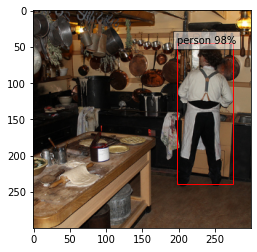

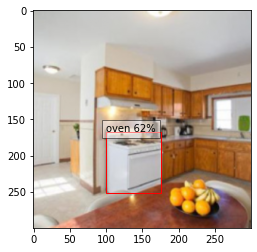

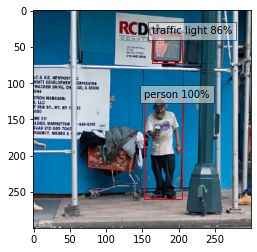

In [17]:
# Visualize results with Torch-TensorRT
plot_results(best_results_per_input_trt)

We get similar results as before!

---
## 6. Measuring Speedup
We can run the benchmark function again to see the speedup gained! Compare this result with the same batch-size of input in the case without Torch-TensorRT above.

In [18]:
batch_size = 128

# Recompiling with batch_size we use for evaluating performance
trt_model = torch_tensorrt.compile(traced_model,
    inputs = [torch_tensorrt.Input((batch_size, 3, 300, 300), dtype=torch.half)],
    enabled_precisions= {torch.half}, # Run with FP16
    workspace_size= 1 << 20
)

benchmark(trt_model, input_shape=(batch_size, 3, 300, 300), dtype='fp16', nruns=100)

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x
- Disable partial compilation by setting require_full_compilation to True


Warm up ...
Start timing ...
Iteration 10/100, avg batch time 45.88 ms
Iteration 20/100, avg batch time 46.20 ms
Iteration 30/100, avg batch time 46.10 ms
Iteration 40/100, avg batch time 46.19 ms
Iteration 50/100, avg batch time 46.15 ms
Iteration 60/100, avg batch time 46.17 ms
Iteration 70/100, avg batch time 46.19 ms
Iteration 80/100, avg batch time 46.20 ms
Iteration 90/100, avg batch time 46.22 ms
Iteration 100/100, avg batch time 46.21 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 46.21 ms


---
## 7. Conclusion

In this notebook, we have walked through the complete process of compiling a TorchScript SSD300 model with Torch-TensorRT, and tested the performance impact of the optimization. We find that using the Torch-TensorRT compiled model, we gain significant speedup in inference without any noticeable drop in performance!

### Details
For detailed information on model input and output,
training recipies, inference and performance visit:
[github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)
and/or [NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)

### References

 - [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper
 - [Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012) paper
 - [SSD on NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)
 - [SSD on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)